<a href="https://colab.research.google.com/github/arvindcsekar/GW-PTA-PINN/blob/main/PTA_GW_PINN_most_accurate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First 10 omega values (rad/s): [5.00000000e-07 5.00000165e-07 5.00000329e-07 5.00000494e-07
 5.00000658e-07 5.00000823e-07 5.00000987e-07 5.00001152e-07
 5.00001317e-07 5.00001481e-07]


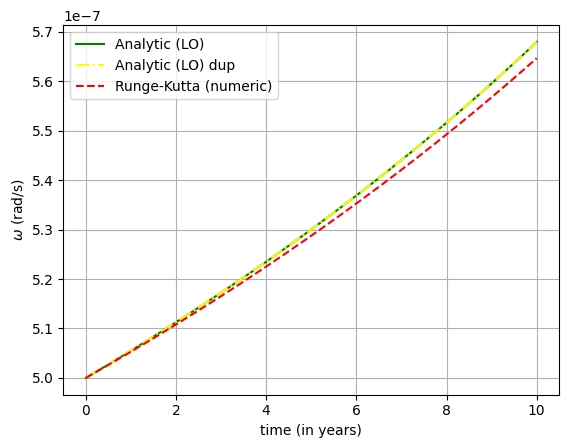

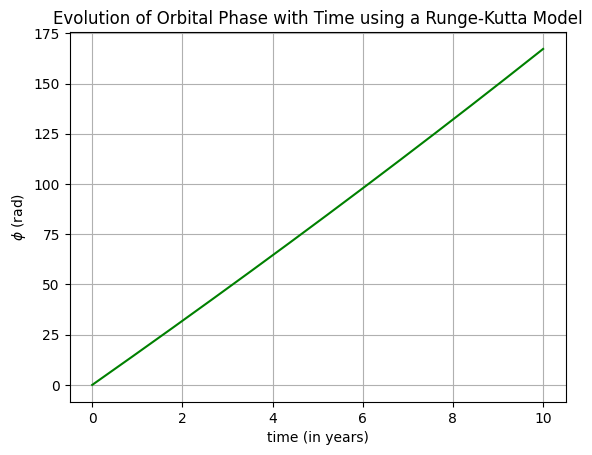

/tmp/ipython-input-2921655728.py:178: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  delta=np.sqrt(1-4*eta)


Epoch 0 | Total: 19961748526.03603 | BC: 0.22180 | Residual: 0.00000
Epoch 100 | Total: 60.29252 | BC: 0.00000 | Residual: 0.00000
Epoch 200 | Total: 0.00026 | BC: 0.00000 | Residual: 0.00000
Epoch 300 | Total: 0.00000 | BC: 0.00000 | Residual: 0.00000
Epoch 400 | Total: 0.00000 | BC: 0.00000 | Residual: 0.00000
Epoch 500 | Total: 0.00000 | BC: 0.00000 | Residual: 0.00000
Epoch 600 | Total: 0.00000 | BC: 0.00000 | Residual: 0.00000
Epoch 700 | Total: 0.00000 | BC: 0.00000 | Residual: 0.00000
Epoch 800 | Total: 0.00000 | BC: 0.00000 | Residual: 0.00000
Epoch 900 | Total: 0.00000 | BC: 0.00000 | Residual: 0.00000
Sample predicted omega (Hz): [[5.00000000e-07]
 [5.01441116e-07]
 [5.06650812e-07]]


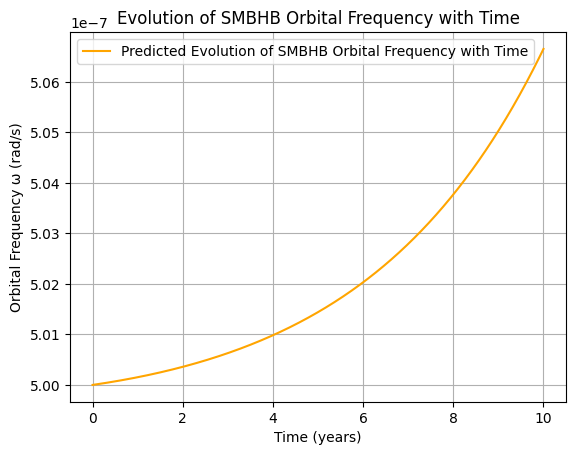

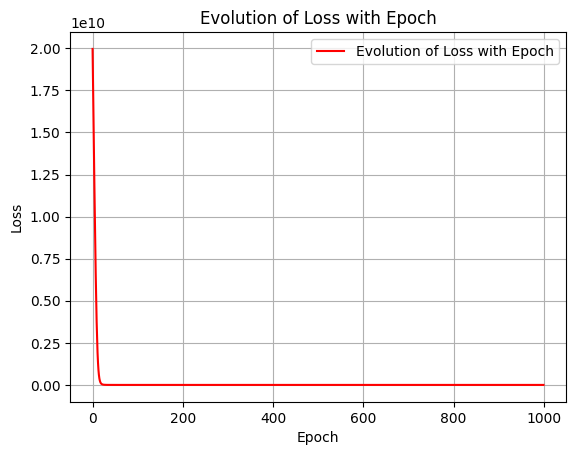

[φ] Epoch 0 | Total 2.507e+11 | BC 1.433e+00 | Resid 2.507e+04
[φ] Epoch 100 | Total 4.858e+09 | BC 2.883e+02 | Resid 1.974e+02
[φ] Epoch 200 | Total 2.007e+09 | BC 8.540e+01 | Resid 1.153e+02
[φ] Epoch 300 | Total 1.238e+09 | BC 5.822e+01 | Resid 6.553e+01
[φ] Epoch 400 | Total 6.555e+08 | BC 4.265e+01 | Resid 2.290e+01
[φ] Epoch 500 | Total 3.899e+08 | BC 2.714e+01 | Resid 1.185e+01
[φ] Epoch 600 | Total 3.085e+08 | BC 2.182e+01 | Resid 9.028e+00
[φ] Epoch 700 | Total 5.547e+08 | BC 1.915e+01 | Resid 3.632e+01
[φ] Epoch 800 | Total 5.413e+08 | BC 2.534e+01 | Resid 2.879e+01
[φ] Epoch 900 | Total 6.356e+08 | BC 1.107e+01 | Resid 5.250e+01


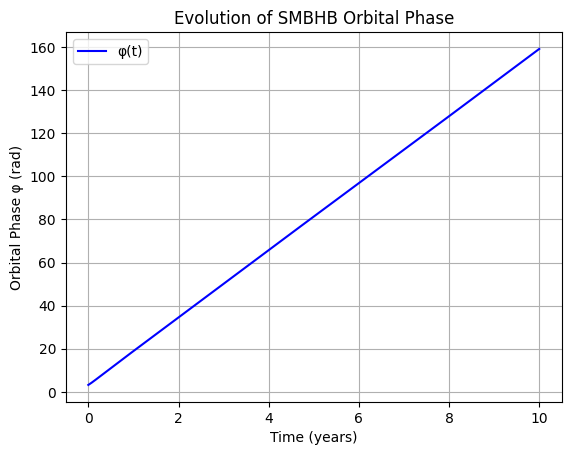

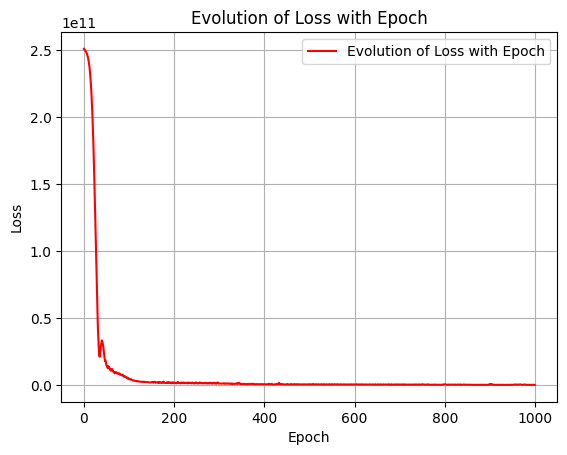

In [18]:
#correct analytic:

import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as ac
import astropy.units as u

G = ac.G.value #big G constant
c = ac.c.value #light

m = 1e9 * ac.M_sun.value  #mass of one SMBH in kg (1e9 M_sun)
m_total = 2 * m #total mass
eta = 0.25 #assuming both SMBHs are identical mass
nu = 1 #stated (keeps structure from original)
chi = 0.5 #high spin SMBH assumed (equal, aligned spin)
omg_a = (5e-7 / u.s).to(1/u.s).value #initial orbital angular frequency (rad/s)
# chirp mass for equal masses: M * eta^(3/5)
m_chirp = m_total * eta**(3/5)

GMsun = ac.GM_sun.value
dsun = GMsun/(c**2)
tsun = GMsun/(c**3)
pc = ac.pc.value
chi_S = 0.5
chi_A = 0.5
delta=np.sqrt(1-4*eta)
Q_15=(-113/12*chi_A*delta+19/3*chi_S*eta-113/12*chi_S+4*np.pi)

def f(t, omg):
    tN_omg = (G * m_chirp * omg / c**3)  #dimensionless combination
    tm_omg_1 = (G * m_total * omg / c**3)
    K = 96.0/5.0 * (G * m_chirp / c**3)**(5.0/3.0)
    #PN correction factor (keeps original functional dependence, but applied as multiplier)
    PN_factor = 1.0 + (59/18*eta**2 + 13661/2016*eta + 34103/18144) * tm_omg_1**(4.0/3.0) * nu**2 \
                   + tm_omg_1 * nu**(3.0/2.0) * Q_15 + (-11/4*eta - 743/336) * tm_omg_1**(2.0/3.0) * nu
    return K * omg**(11.0/3.0) * PN_factor

def rk4(f, omg_0, t_f, t_0, h):
  n_steps = int((t_f - t_0)/h + 1) #define number of steps
  t = np.linspace(t_0, t_f, n_steps)
  omg = np.zeros(n_steps) #initialises empty omg array of the size of n_steps
  omg[0] = omg_0 #omg_0 at time t initialised

  for i in range(1, n_steps):
    k1 = h * f(t[i-1], omg[i-1])  #initial slope
    k2 = h * f(t[i-1] + h/2, omg[i-1] + k1/2)  #slope at midpoint using k1
    k3 = h * f(t[i-1] + h/2, omg[i-1] + k2/2)  #slope at midpoint using k2
    k4 = h * f(t[i-1] + h, omg[i-1] + k3)      #end slope using k3

    omg[i] = omg[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6  #combine weighted slopes

  return t, omg

omg_0 = omg_a
t_0 = 0
t_f = (10 * u.yr).to(u.s).value
h = (1000 * u.s).to(u.s).value

t, omg = rk4(f, omg_0, t_f, t_0, h)
t_years = t / (u.yr.to(u.s))

print("First 10 omega values (rad/s):", omg[:10])  # first 10 omega values

def get_omg(t, t_a, omg_a, m_c, eta, nu, chi_A, chi_S):
    K = 96.0/5.0 * (G * m_c / c**3)**(5.0/3.0)
    t_sec = np.asarray(t, dtype=float)  # t in seconds
    omega0 = omg_a
    denom = omega0**(-8.0/3.0) - (8.0/3.0) * K * (t_sec - t_a)
    denom = np.maximum(denom, 1e-50)
    omega = denom**(-3.0/8.0)
    return omega

t_test = np.linspace(0,10,100) * (u.yr.to(u.s))
m_c = m_chirp
eta = 1/4
nu = 1
chi_A = chi_S = 0.5

omg_arr = get_omg(t_test, t_0, omg_a, m_c, eta, nu, chi_A, chi_S)
omg_arr_Q = get_omg(t_test, t_0, omg_a, m_c, eta, nu, chi_A, chi_S)

plt.plot(t_test/ (u.yr.to(u.s)), omg_arr, linestyle="-", color="green")
plt.plot(t_test/ (u.yr.to(u.s)), omg_arr_Q, linestyle="-.", color="yellow")
plt.plot(t_years, omg, linestyle="--", color="red")
plt.grid(True)
plt.legend(["Analytic (LO)", "Analytic (LO) dup","Runge-Kutta (numeric)"])
plt.xlabel("time (in years)")
plt.ylabel(r"$\omega$ (rad/s)")
plt.show()

def rk4_phi(f, omg, phi_0, t_f, t_0, h):
  n_steps2 = int((t_f - t_0)/h + 1) #define number of steps
  t = np.linspace(t_0, t_f, n_steps2)
  phi = np.zeros(n_steps2) #initialises empty phi array of the size of n_steps2
  phi[0] = phi_0 #phi_0 at time t initialised

  t_omg = np.linspace(t_0, t_f, len(omg))

  def omega_of_tau(tau):
      return np.interp(tau, t_omg, omg)

  for w in range(0, n_steps2-1):
    h_local = t[w+1] - t[w]
    ti = t[w]

    k1 = omega_of_tau(ti)
    k2 = omega_of_tau(ti + 0.5*h_local)
    k3 = omega_of_tau(ti + 0.5*h_local)
    k4 = omega_of_tau(ti + h_local)

    phi[w+1] = phi[w] + (h_local/6.0)*(k1 + 2*k2 + 2*k3 + k4)

  return t, phi

omg_0 = omg_a
t_0 = 0
t_f = (10 * u.yr).to(u.s).value
h = (1000 * u.s).to(u.s).value
phi_0 = 0

t, phi = rk4_phi(f, omg, phi_0, t_f, t_0, h)
t_years = t / (u.yr.to(u.s))

plt.plot(t_years, phi, color="green")
plt.grid(True)
plt.title("Evolution of Orbital Phase with Time using a Runge-Kutta Model")
plt.xlabel("time (in years)")
plt.ylabel(r"$\phi$ (rad)")
plt.show()


#main one, no analytic, 99% PINN w batching
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as ac
import astropy.units as u

G = ac.G.value #big G constant
c = ac.c.value #light
M_sun = ac.M_sun.value
m_one = 1e9 * M_sun         # kg
m_total = 2.0 * m_one       # kg
nu = 1 #stated
eta = 0.25 #assuming both SMBHs of identical mass (1e9 solar masses)
omg_a = (5e-7 / u.s).to(1/u.s).value #from Kepler relation
m_chirp = (eta**(3/5)) * m_total  # kg
m_c = m_chirp
omg_positive = (5e-7 / u.s).to(1/u.s).value
yr = u.yr.to(u.s)
GMsun = ac.GM_sun.value
dsun = GMsun/(c**2)
tsun = GMsun/(c**3)
pc = ac.pc.value
chi_S = 0.5
chi_A = 0.5

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import astropy.constants as ac

torch.manual_seed(42)
np.random.seed(42)
G = torch.tensor(ac.G.value, dtype=torch.float64) #big G constant
c = torch.tensor(ac.c.value, dtype=torch.float64) #light
m = 1e9
m_c = m_chirp = torch.tensor((m**2)**(3/5) / ((2 * m )**(1/5)), dtype=torch.float64)  # chirp mass
m_total = torch.tensor(2*m, dtype=torch.float64) #total mass
nu = torch.tensor(1.0, dtype=torch.float64) #stated
eta = torch.tensor(0.25, dtype=torch.float64) #assuming both SMBHs of identical mass (1e9 solar masses)
chi = torch.tensor(0.5, dtype=torch.float64) #high spin SMBH assumed (equal, aligned spin)
m=m_c/eta**(3/5)
tN_ = m_c*omg_a*tsun
tm_ = m*omg_a*tsun
delta=np.sqrt(1-4*eta)
Q_15 =(-113/12*chi_A*delta+19/3*chi_S*eta-113/12*chi_S+4*np.pi)
omg_a = (5e-7 / u.s).to(1/u.s).value #from Kepler relation

class PINN(nn.Module):
  def __init__(self):
    super(PINN, self).__init__()
    self.net = nn.Sequential(
      nn.Linear(1, 64), #input 1 neuron (time), then 32 neurons in each hidden layer
      nn.Tanh(), #activation function
      nn.Linear(64, 64),
      nn.Tanh(),
      nn.Linear(64, 64),
      nn.Tanh(),
      nn.Linear(64, 64),
      nn.Tanh(),
      nn.Linear(64, 1, bias=True) #output layer, 1 neuron (solution, omega)
    )
    self.double() #Ensure the model parameters are of type float64


  def forward(self, t):
    return torch.sigmoid(self.net(t))

num_points = 10000
t_end = (10 * u.yr).to(u.s).value  #10 years in seconds
t_0 = 0
t = torch.rand(num_points, 1, dtype=torch.float64) #b/w t=0 and coalescence time, NORMALISED
input = t.requires_grad_() #tells PyTorch to track gradients wrt inputs
omg_enforced = torch.tensor((5e-7 / u.s).to(1/u.s).value, dtype=torch.float64) #kepler's relation for typical omg value at t=0, with M = 1e9 and R = 0.1pc

t_bc2 = torch.tensor([0.0], dtype=torch.float64).view(-1, 1)
loss_MSE = nn.MSELoss() #mean squared


#weights
w1 = 9e10
w2 = 7


def compute_residual_loss(model, t_batch):
    t_pred = t_batch.requires_grad_()
    omg_pred = model(t_pred)
    tN_omg = (G * m_chirp * omg_pred / (c**3)) ** (5/3)
    t_phys = t_pred * t_end
    tmta = t_phys

    tN_ref = m_c * omg_a * tsun
    tau = 1.0 - (256.0/5.0) * omg_a * (tN_ref**(5.0/3.0)) * t_phys
    tau = torch.clamp(tau, min=1e-12)


    omg_positive = omg_pred
    t_physical = t_pred * t_end
    tN_omg = (G * m_chirp * omg_positive / (c**3))
    tm_omg = (G * m_total * omg_positive / (c**3))  #For Q_15 term

    domg_dt = torch.autograd.grad(omg_positive, t_pred, grad_outputs=torch.ones_like(omg_positive),create_graph=True)[0]/t_end
    rhs = (96/5) * (
    1
    + ((59/18*eta**2 + 13661/2016*eta + 34103/18144)/tau**(7/8)) * tm_omg**(4/3) * nu**2
    + ((-11/4*eta - 743/336)/tau**(5/8)) * tm_omg**(2/3) * nu
    + (Q_15 / tau**(3/4)) * tm_omg * nu**(3/2)
) * omg_positive**2 * tN_omg**(5/3)


    residual = domg_dt - rhs #LHS - RHS of provided equation
    residual_loss = torch.mean(residual**2) #mean squared
    return residual_loss

model = PINN()
optimiser = optim.Adam(model.parameters(), lr=1e-3) #Adam optimiser w learning rate


batch_size = 1024
epoch_num = 1000
loss_arr = np.zeros(epoch_num)
for epoch in range(epoch_num):
  optimiser.zero_grad() #clears old grads

  omg_pred_bc2 = model(t_bc2) #runs BC sampling point through PINN
  omg_target_bc2 = omg_enforced.view(-1,1) #omg = enforced value at t_0

  bc_loss = loss_MSE(omg_pred_bc2, omg_target_bc2)
  indices = torch.randperm(num_points)[:batch_size] #picks random batch from collocation points, makes sure it's not picked again
  t_batch = t[indices].requires_grad_() #computes gradients
  residual_loss = compute_residual_loss(model, t_batch)

  omg_pred = model(t)

  total_loss = w1 * bc_loss + w2 * residual_loss
  total_loss.backward() #back propagation, calculates how much weights should change
  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
  loss_arr[epoch] = total_loss.item()
  optimiser.step() #updates weights using gradients computed in back propagation

  if epoch % 100 == 0:
        print(f"Epoch {epoch} | Total: {total_loss.item():.5f} | BC: {bc_loss.item():.5f} | Residual: {residual_loss.item():.5f}")

t_values = np.linspace(0, 1, 1000) #normalised
t_tensor = torch.tensor(t_values, dtype=torch.float64).view(-1, 1)
t_tensor_upscale = t_tensor * t_end #upscale
omg_tensor = model(t_tensor)
omega_arr = np.zeros(1000)
print("Sample predicted omega (Hz):", model(torch.tensor([[0.0], [0.5], [1.0]], dtype=torch.float64)).detach().numpy())

t_np = (t_tensor_upscale / u.yr.to(u.s)).detach().numpy() #converting back
omg_np = omg_tensor.detach().numpy()

plt.plot(t_np, omg_np, label="Predicted Evolution of SMBHB Orbital Frequency with Time", color="orange")
plt.title("Evolution of SMBHB Orbital Frequency with Time")
plt.xlabel('Time (years)')
plt.ylabel('Orbital Frequency ω (rad/s)')
plt.legend()

plt.grid()
plt.show()

plt.plot(range(epoch_num), loss_arr, label = "Evolution of Loss with Epoch", color="red")
plt.title("Evolution of Loss with Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.grid()
plt.show()

class PINN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        self.double()

    def forward(self, t):
        return torch.exp(self.net(t))

def compute_residual_loss_phi(model2, t_batch, model):
    t_pred = t_batch.requires_grad_()
    phi_pred = model2(t_pred)

    dphi_dtau = torch.autograd.grad(phi_pred, t_pred, grad_outputs=torch.ones_like(phi_pred), create_graph=True)[0]
    omega_here = model(t_pred)

    residual = dphi_dtau - omega_here * t_end
    return torch.mean(residual**2)

phi_enforced = torch.tensor([[0.0]], dtype=torch.float64)
model2 = PINN2()
opt_phi = optim.Adam(model2.parameters(), lr=1e-3)
loss_arr_phi = []
w1 = w2 = 1e7

for epoch in range(epoch_num):
    opt_phi.zero_grad()
    phi_pred_bc = model2(t_bc2)
    bc_loss = loss_MSE(phi_pred_bc, phi_enforced)

    idx = torch.randperm(num_points)[:1024]
    t_batch = t[idx]
    residual_loss = compute_residual_loss_phi(model2, t_batch, model)

    total_loss = w1 *bc_loss + w2 * residual_loss
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
    opt_phi.step()

    loss_arr_phi.append(total_loss.item())
    if epoch % 100 == 0:
        print(f"[φ] Epoch {epoch} | Total {total_loss.item():.3e} | BC {bc_loss.item():.3e} | Resid {residual_loss.item():.3e}")

t_vals = torch.linspace(0, 1, 1000, dtype=torch.float64).view(-1,1)
t_phys = t_vals * t_end

phi_pred = model2(t_vals).detach().numpy()

t_years = (t_phys / u.yr.to(u.s)).detach().numpy()


plt.plot(t_years, phi_pred, label="φ(t)", color="blue")
plt.xlabel("Time (years)")
plt.ylabel("Orbital Phase φ (rad)")
plt.title("Evolution of SMBHB Orbital Phase")
plt.grid()
plt.legend()
plt.show()

plt.plot(range(epoch_num), loss_arr_phi, label = "Evolution of Loss with Epoch", color="Red")
plt.title("Evolution of Loss with Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.grid()
plt.show()
